# Faryar Memon
##### ID: 14770bef0541f000 <br>
-----
#### STAGE C: Machine Learning: Classification - Managing the Quality Metric of Global Ecological Footprint
----- 
<br>Dataset ([Electrical Grid Stability Simulated Data](https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simulated+Data+))

    Dataset Description:
        1. Predictive Features [Predictors]: 
        - 'tau1' to 'tau4': the reaction time of each network participant, a real value within the range 0.5 to 10 ('tau1' corresponds to the supplier node, 'tau2' to 'tau4' to the consumer nodes);
        - 'p1' to 'p4': nominal power produced (positive) or consumed (negative) by each network participant, a real value within the range -2.0 to -0.5 for consumers ('p2' to 'p4'). As the total power consumed equals the total power generated, p1 (supplier node) = - (p2 + p3 + p4);
        - 'g1' to 'g4': price elasticity coefficient for each network participant, a real value within the range 0.05 to 1.00 ('g1' corresponds to the supplier node, 'g2' to 'g4' to the consumer nodes; 'g' stands for 'gamma');
        
        2. Dependent Variables [Target]:
        'stab': the maximum real part of the characteristic differential equation root (if positive, the system is linearly unstable; if negative, linearly stable);
        - 'stabf': a categorical (binary) label ('stable' or 'unstable').
<br>





In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, LeaveOneOut, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import recall_score, accuracy_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.style.use('dark_background')

In [2]:
path = 'Data_for_UCI_named.csv'
df = pd.read_csv(path)

In [3]:
df.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


### Understanding the dataset; data types, basic stats of each columns and finding missing values & duplicated rows.



In [4]:
def DB_Info(df):
    """
    Returns detailed information about the dataset such as it's data types, 
    basics statistics, number of missing values in each columns & duplicated rows
    """
    print(f'Shape of the dataset ->> {df.shape}')
    print('-'*20)
    print(df.info())
    print('-'*20)
    print(df.describe(include='all'))
    print('-'*20)
    d = df.isnull().sum()
    # prints the columns with null values with a total count of null values it contains
    if d[d>0].any():
        print(d[d>0])
    else:
        print('There are no null values')
    print('-'*20)
    # prints the duplicated rows
    if df.duplicated().any():
        print(df[df.duplicated()])
    else:
        print('There are no duplicated rows')
    print('-'*20)
    for col in df.columns:
        a = df[col].unique()
        if len(a)<15:
            print(f'{col} has {len(a)} unique values ->> {a}', end = '\n\n')
    
DB_Info(df)

Shape of the dataset ->> (10000, 14)
--------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    10000 non-null  float64
 1   tau2    10000 non-null  float64
 2   tau3    10000 non-null  float64
 3   tau4    10000 non-null  float64
 4   p1      10000 non-null  float64
 5   p2      10000 non-null  float64
 6   p3      10000 non-null  float64
 7   p4      10000 non-null  float64
 8   g1      10000 non-null  float64
 9   g2      10000 non-null  float64
 10  g3      10000 non-null  float64
 11  g4      10000 non-null  float64
 12  stab    10000 non-null  float64
 13  stabf   10000 non-null  object 
dtypes: float64(13), object(1)
memory usage: 1.1+ MB
None
--------------------
                tau1          tau2          tau3          tau4            p1  \
count   10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
uni

As stated in the output, the dataset consists of 10000 entries (rows) & 14 columns (variables).
<br>There are no missing values and duplicated rows.

In [5]:
df.drop(columns=['stab'], inplace=True)
df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,unstable
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.930406,9.487627,2.376523,6.187797,3.343416,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385,unstable
9996,3.392299,1.274827,2.954947,6.894759,4.349512,-1.663661,-0.952437,-1.733414,0.502079,0.567242,0.285880,0.366120,stable
9997,2.364034,2.842030,8.776391,1.008906,4.299976,-1.380719,-0.943884,-1.975373,0.487838,0.986505,0.149286,0.145984,stable
9998,9.631511,3.994398,2.757071,7.821347,2.514755,-0.966330,-0.649915,-0.898510,0.365246,0.587558,0.889118,0.818391,unstable


unstable    6380
stable      3620
Name: stabf, dtype: int64


<AxesSubplot:xlabel='stabf', ylabel='Count'>

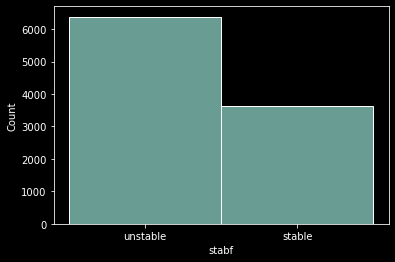

In [6]:
print(df.stabf.value_counts())
sns.histplot(data=df, x='stabf')

In [7]:
X = df.drop(columns=['stabf'])
Y = df['stabf']

In [8]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)
y_train.value_counts(), y_test.value_counts()

(unstable    5092
 stable      2908
 Name: stabf, dtype: int64,
 unstable    1288
 stable       712
 Name: stabf, dtype: int64)

There still remains an unbalanced in the classes, hence oversampling using SMOTE

In [9]:
# balancing the training set
smote = SMOTE(random_state=1)
x_train_balanced, y_train_balanced = smote.fit_resample(x_train, y_train)

In [10]:

s_scalar = StandardScaler()
n_train_df = s_scalar.fit_transform(x_train_balanced)
n_train_df = pd.DataFrame(n_train_df, columns=x_train_balanced.columns)
n_train_df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,0.431352,-0.906078,0.709472,1.601487,-0.299634,0.070986,1.327370,-0.875325,0.227072,0.416592,0.675795,0.567770
1,0.007043,0.151748,1.089400,-1.545174,0.636265,-0.061013,-1.541948,0.492481,-0.241282,-1.540004,1.547891,-1.427980
2,-1.371213,1.340884,-0.429412,1.225073,-0.185676,0.510814,0.700214,-0.885831,1.504487,1.562377,-1.009660,0.568027
3,0.876060,0.585001,1.350743,-1.052290,-0.835039,-0.774873,1.560992,0.669318,-0.927397,1.470053,1.728175,0.344110
4,0.724152,-1.338448,0.375461,0.981443,-1.658064,0.787290,1.458851,0.649251,1.790768,0.783310,1.246050,-1.292976
...,...,...,...,...,...,...,...,...,...,...,...,...
10179,-0.373458,-1.117658,0.568207,-1.519188,-1.076505,0.785933,-0.001746,1.096330,-0.584156,-0.276447,0.041123,0.826954
10180,-1.451654,-0.835561,1.222408,1.185053,-1.326430,1.205379,-0.164007,1.276288,1.477809,-0.539330,-0.581280,-1.108805
10181,-0.010422,-1.306042,-1.527579,-0.549530,-1.359934,0.040556,1.035499,1.297329,0.663560,-0.452264,0.166377,-1.489641
10182,-0.267590,-1.382194,-1.213566,1.501028,0.403488,0.774435,-1.716730,0.239997,-0.882891,-0.033430,-1.215899,1.243240


In [11]:
x_test.reset_index(drop=True)
n_test_df = s_scalar.transform(x_test)
n_test_df = pd.DataFrame(n_test_df, columns=x_test.columns)
n_test_df

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,0.653948,-0.342180,1.552512,1.176622,0.413993,-1.522503,-0.805438,1.601947,-0.868280,1.269322,-1.486568,1.178617
1,0.269149,0.432049,-0.119513,-0.440814,-0.232346,-1.077119,0.430894,1.049196,-1.615807,-0.341497,1.532396,1.324281
2,-0.989316,-0.244817,-0.806837,0.091369,-0.968815,0.123386,0.822070,0.745556,1.564064,-1.416330,0.744247,-1.674023
3,-0.011091,-1.025372,0.435225,-1.610946,0.774002,-1.671140,0.414230,-0.097754,0.147033,-1.657332,-0.298796,1.148862
4,0.928943,1.478634,0.152582,1.766771,-0.158318,0.000717,-0.202210,0.477796,0.201936,-1.448524,1.058931,-0.784855
...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.170334,-0.600358,-1.299022,1.345274,0.255993,-0.815562,0.753498,-0.386608,0.562166,-0.052769,-1.235867,-1.262605
1996,-0.988205,-0.731639,1.087790,0.407667,-0.171367,0.357370,1.013663,-1.071176,1.043453,0.986463,-1.026976,-1.067745
1997,1.001534,-1.572639,-1.566715,0.600105,-1.559514,1.637929,0.093942,0.993555,-1.211717,0.196573,0.663270,1.420512
1998,-1.029775,0.254573,-0.167918,0.490486,-1.194277,0.765135,0.028030,1.292836,1.633407,0.884757,-1.336748,-0.766549


### NOTE: I restarted the kernel and ran all the cells, and all my values changed. I'll mention the old values as well which seems to be incorrect.

## Question 3
Find the feature importance using optimal ExtraTreesClassifier model. Which features are the most and least important features respectively?

In [12]:
## Extra Trees Classifier
et_model = ExtraTreesClassifier(random_state=1)
et_model.fit(n_train_df, y_train_balanced)
et_pred = et_model.predict(n_test_df)

In [13]:
f_imp = et_model.feature_importances_

In [14]:
features = {'Feature Names': n_test_df.columns, 'Feature Importance': f_imp}
features

{'Feature Names': Index(['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2',
        'g3', 'g4'],
       dtype='object'),
 'Feature Importance': array([0.11971508, 0.11765325, 0.11417414, 0.11849404, 0.03701265,
        0.03779585, 0.0380866 , 0.03803685, 0.09157514, 0.09483179,
        0.09979064, 0.09283399])}

In [15]:
features_df = pd.DataFrame(features)
features_df.sort_values(by=['Feature Importance'], ascending=False, inplace=True)

<AxesSubplot:xlabel='Feature Importance', ylabel='Feature Names'>

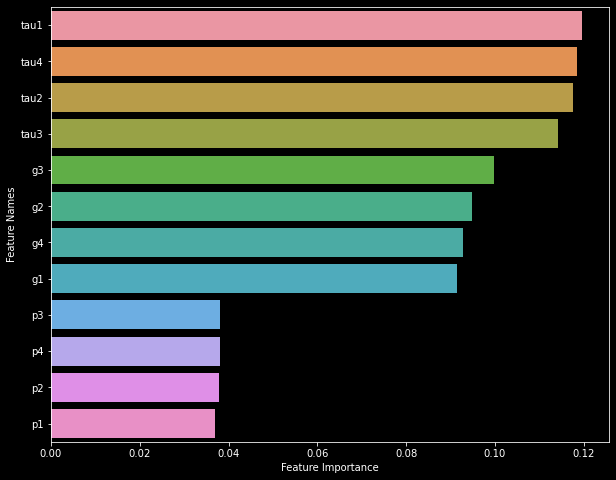

In [16]:
plt.figure(figsize=(10,8))
sns.barplot(x=features_df['Feature Importance'], y=features_df['Feature Names'])

### Answer:
According to the bar plot, the most important feature is <strong>tau1</strong> and least important feature is <strong>p1</strong>.

## Question 6
What is the acurracy on the test set using the random forest classifier? In 4 decimal places.

In [17]:
## Random Forest Classifier

rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(n_train_df, y_train_balanced)
rf_pred = rf_model.predict(n_test_df)

In [18]:
acc = accuracy_score(y_test, rf_pred)
print(f'The accuracy of Random Forest Classifier is {round(acc, 4)}')

The accuracy of Random Forest Classifier is 0.918


### Answer:
The accuracy of Random Forest Classifier is 0.918.
<br>Old Value before Kernal restart: 0.9995

## Question 11
What is the accuracy on the test set using LGBM Classifier? In 4 decimal places.


In [19]:
## lightGBM Model

lgb_model = lgb.LGBMClassifier(verbosity = 0, random_state = 1)
lgb_model.fit(n_train_df, y_train_balanced)
lgb_pred = lgb_model.predict(n_test_df)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [20]:
acc1 = accuracy_score(y_test, lgb_pred)
print(f'The accuracy of LightGBoost is {round(acc1, 4)}.')

The accuracy of LightGBoost is 0.935.


### Answer:
The accuracy of LightGBoost is 0.935.
<br>Old Value before Kernal restart: 0.9965.

## Question 12
Train a new ExtraTreeClassifier Model from the RandomizedSearchCV (with random_state = 1). Is the accuracy of the new optimal model higher or lower than the initial ExtraTreeClassifier model with no hyperparameter tuning?


In [21]:
et_model1 = ExtraTreesClassifier(random_state=1)
et_model1.fit(n_train_df, y_train_balanced)
et_pred1 = et_model1.predict(n_test_df)

In [22]:
param_dist = {
'n_estimators': list(range(50, 300, 10)),
'min_samples_leaf': list(range(1, 50)),
'max_depth': list(range(2, 20)),
'max_features': ['auto', 'sqrt'],
'bootstrap': [True, False]}
# specify number of search iterations
n_iter = 50
# Instantiate RandomSearchCV
model_random_search = RandomizedSearchCV(estimator=et_model1, param_distributions=param_dist, n_iter=n_iter)

In [23]:
model_random_search.fit(n_train_df, y_train_balanced)

RandomizedSearchCV(estimator=ExtraTreesClassifier(random_state=1), n_iter=50,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                             27, 28, 29, 30, ...],
                                        'n_estimators': [50, 60, 70, 8

In [24]:
y_pred_random = model_random_search.predict(n_test_df)
accuracy_random = accuracy_score(y_test, y_pred_random)

In [25]:
print(model_random_search.best_estimator_)
print(f'The accuracy of Random Grid Search is {round(accuracy_random, 4)}')

ExtraTreesClassifier(max_depth=14, min_samples_leaf=3, n_estimators=270,
                     random_state=1)
The accuracy of Random Grid Search is 0.9155


In [26]:
acc = accuracy_score(y_test, et_pred)
print(f'The accuracy of Initial ExtraTreesClassifier is {round(acc, 4)}')

The accuracy of Initial ExtraTreesClassifier is 0.919


### Answer:
The accuracy of Initial ExtraTreesClassifier is 0.919.


## Question 15

In [27]:
## XGBoost Model

xgb_model = xgb.XGBClassifier(verbosity = 0, random_state = 1)
xgb_model.fit(n_train_df, y_train_balanced)
xgb_pred = xgb_model.predict(n_test_df)

In [28]:
acc2 = accuracy_score(y_test, xgb_pred)
print(f'The accuracy of XGBoost is {round(acc2, 4)}')

The accuracy of XGBoost is 0.9415


### Answer:
The accuracy of XGBoost is 0.9415.
<br>Old Value before Kernal restart: 0.9995